# Trénovanie modelu iba na základe DST indexu 4h dopredu 6 dozadu
Súbor: 6_dozadu_4_dopredu.ipynb

Program: Hospodárska informatika

Vypracovala: Bc. Veronika Motúzová

Diplomová práca: : Predikcia geomagnetickych búrok pomocou hlbokého učenia

Vedúci diplomovej práce: doc. Ing. Peter Butka, PhD.

Konzultanti: Ing. Viera Maslej Krešňáková, PhD., RNDr. Šimon Mackovjak, PhD. 

### Inštalácia knižníc

In [1]:
!pip install pyarrow
!pip install keras
!pip install --upgrade tensorflow
!pip install --upgrade tensorflow-gpu

### Kontrola kapacity servera

In [2]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


### Import knižníc

In [1]:
import pandas as pd
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns

from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential

from keras.layers import Dense, Activation, Dropout, Input, Conv1D, LSTM, MaxPooling1D, Flatten, TimeDistributed, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Model


from scipy.special import expit, logit

from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef

### Načitanie dát, odstránenie na hodnôt, určenie predikovaného atribútu

In [2]:
train = pd.read_csv('train_omni.csv')
test = pd.read_csv('test_omni.csv')
features = ['time1',
           'DST',
            'DST+4']
test = test[features]
train = train[features]
train['time1']=pd.to_datetime(train['time1'])
test['time1']=pd.to_datetime(test['time1'])
predicted_label = 'DST+4'

y_col='DST+4'
valid_size = int(len(train) * 0.2)
valid = train.iloc[-valid_size:,:].copy()
train = train.iloc[:-valid_size,:].copy()

y_train = train[y_col].values.copy()
X_train = train['DST'].values.copy()
y_val = valid[y_col].values.copy()
X_val = valid['DST'].values.copy()
y_test = test[y_col].values.copy()
X_test = test['DST'].values.copy()

In [3]:
# set batch, n_input, n_features

n_input = 6  # how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features= len(X_train)  # how many predictors/Xs/features we have to predict y
b_size = 256  # Number of timeseries samples in each batch

train_generator = TimeseriesGenerator(X_train, y_train, length=n_input, batch_size=b_size)
val_generator = TimeseriesGenerator(X_val, y_val, length=n_input, batch_size=b_size)
test_generator = TimeseriesGenerator(X_test, y_test, length=n_input, batch_size=256)

In [4]:
print("Počet batchov: ", len(train_generator))
print("Každý batch má features (X zložku) a labels (y zložku): ", len(train_generator[0]))
print("Dĺžka X zložky batchu: ", len(train_generator[0][0]))
print("Dĺžka y zložky batchu (počet meraní v batchi): ",len(train_generator[0][1]))
print("Počet riadkov braných do úvahy pre jedno meranie (koľko sa pozerá dozadu): ", len(train_generator[0][0][0]))

Počet batchov:  1139
Každý batch má features (X zložku) a labels (y zložku):  2
Dĺžka X zložky batchu:  256
Dĺžka y zložky batchu (počet meraní v batchi):  256
Počet riadkov braných do úvahy pre jedno meranie (koľko sa pozerá dozadu):  6


In [5]:
inputs = Input(shape=(6,1))
c = Bidirectional(LSTM(128, return_sequences=True, dropout=0.1,recurrent_dropout=0.1))(inputs)
c = LSTM(128, return_sequences=True)(c)
c = TimeDistributed(Dense(1, activation='linear'))(c)
output = Flatten()(c)
output = Dense(1, activation='linear')(output)
model = Model(inputs=inputs, outputs=output)
model.compile(loss='mse', optimizer='adam', metrics=["mae"])
print(model.summary())

2023-02-27 23:39:33.333531: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-27 23:39:33.862165: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10787 MB memory:  -> device: 0, name: Tesla K40c, pci bus id: 0000:01:00.0, compute capability: 3.5


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6, 1)]            0         
                                                                 
 bidirectional (Bidirectiona  (None, 6, 256)           133120    
 l)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 6, 128)            197120    
                                                                 
 time_distributed (TimeDistr  (None, 6, 1)             129       
 ibuted)                                                         
                                                                 
 flatten (Flatten)           (None, 6)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 7     

In [6]:
# callbacks
saved_model = "6_dozadu_4_dopredu.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor='val_mae', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor="val_mae", mode="min", patience=25)
callbacks_list = [checkpoint, early]

In [7]:
# fit
history = model.fit(train_generator, validation_data=val_generator, epochs=20, verbose=1, callbacks = callbacks_list)

Epoch 1/20


2023-02-27 23:39:41.650161: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8201


1139/1139 [==============================] - ETA: 0s - loss: 88.5212 - mae: 3.0050
Epoch 1: val_mae improved from inf to 1.89971, saving model to 6_dozadu_4_dopredu.hdf5
1139/1139 [==============================] - 211s 179ms/step - loss: 88.5212 - mae: 3.0050 - val_loss: 38.3483 - val_mae: 1.8997
Epoch 2/20
1139/1139 [==============================] - ETA: 0s - loss: 17.7987 - mae: 1.4455
Epoch 2: val_mae improved from 1.89971 to 1.76460, saving model to 6_dozadu_4_dopredu.hdf5
1139/1139 [==============================] - 201s 177ms/step - loss: 17.7987 - mae: 1.4455 - val_loss: 26.4334 - val_mae: 1.7646
Epoch 3/20
1139/1139 [==============================] - ETA: 0s - loss: 9.3659 - mae: 1.1575
Epoch 3: val_mae did not improve from 1.76460
1139/1139 [==============================] - 204s 179ms/step - loss: 9.3659 - mae: 1.1575 - val_loss: 17.3527 - val_mae: 2.2740
Epoch 4/20
1139/1139 [==============================] - ETA: 0s - loss: 9.6022 - mae: 1.1711
Epoch 4: val_mae did not im

In [8]:
# load best model
model = keras.models.load_model('6_dozadu_4_dopredu.hdf5')

In [9]:
# prediction
y_pred = model.predict(test_generator)

607/607 [==============================] - 10s 16ms/step


In [10]:
y_pred

array([[ 14.816863],
       [ 13.089986],
       [ 13.051527],
       ...,
       [-22.007467],
       [-24.161596],
       [-26.992048]], dtype=float32)

In [11]:
# confusion matrix
# TN FP
# FN TP

y_pred2 = np.where(y_pred <= -20, 1, 0)
# [n_input:] because prediction starts from n-th row
y_test2 = np.where(y_test[n_input:]  <= -20, 1, 0)

cm = confusion_matrix(y_test2, y_pred2)
print("Confusion matrix: \n" + str(cm))

Confusion matrix: 
[[124631      9]
 [  3262  27351]]


In [12]:
print(classification_report(y_test2, y_pred2))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99    124640
           1       1.00      0.89      0.94     30613

    accuracy                           0.98    155253
   macro avg       0.99      0.95      0.97    155253
weighted avg       0.98      0.98      0.98    155253



In [13]:
df = pd.DataFrame(data={"time": test['time1'][n_input:],"y_true": y_test[n_input:].reshape(-1) , "y_predict": y_pred.reshape(-1)})

In [14]:
df

,time,y_true,y_predict
6,2004-07-22 04:00:00,16.0,14.816863
7,2004-07-22 05:00:00,14.0,13.089986
8,2004-07-22 06:00:00,14.0,13.051527
9,2004-07-22 07:00:00,14.0,13.070575
10,2004-07-22 08:00:00,11.0,10.554357
...,...,...,...
155254,2022-04-28 20:00:00,-13.0,-13.140494
155255,2022-04-28 21:00:00,-18.0,-17.473330
155256,2022-04-28 22:00:00,-23.0,-22.007467
155257,2022-04-28 23:00:00,-26.0,-24.161596


In [15]:
df.describe()

,y_true,y_predict
count,155253.000000,155253.000000
mean,-9.816899,-9.191253
std,16.339896,14.974773
min,-374.000000,-298.508453
25%,-16.000000,-15.955691
50%,-7.000000,-6.882450
75%,0.000000,0.321870
max,77.000000,55.832233


<AxesSubplot: >

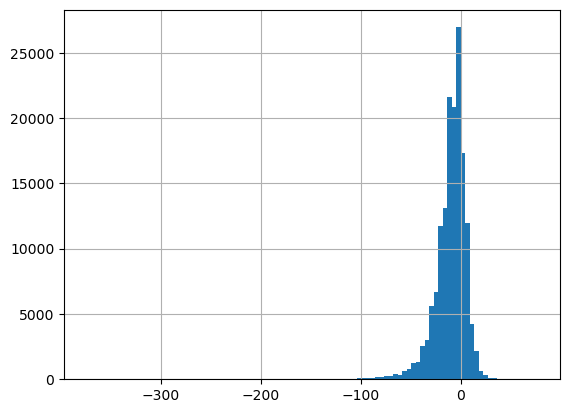

In [16]:
df["y_true"].hist(bins=100)

<AxesSubplot: >

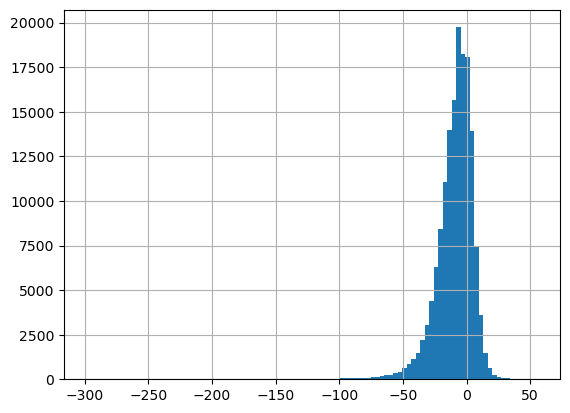

In [17]:
df["y_predict"].hist(bins=100)

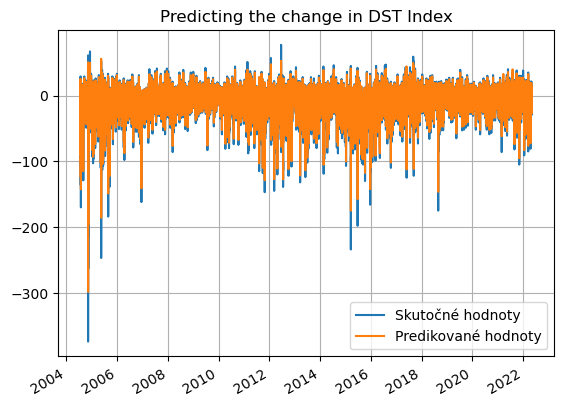

In [18]:
plt.figure()
plt.title('Predicting the change in DST Index')
plt.plot(df['time'],df['y_true'], label='Skutočné hodnoty')
plt.plot(df['time'],df['y_predict'], label='Predikované hodnoty')
plt.legend()
plt.gcf().autofmt_xdate()
plt.grid(True)

In [19]:
df.to_csv('predikcie_6h_dozadu_4h_dopredu.csv')

In [20]:
TN = cm[0,0] 
print(TN)
FP = cm[0,1]
print(FP)
FN = cm[1,0] 
print(FN)
TP = cm[1,1] 
print(TP)
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print("TPR={}".format(TPR))
# Specificity or true negative rate
TNR = TN/(TN+FP)
print("TNR={}".format(TNR))
# Precision or positive predictive value
PPV = TP/(TP+FP)
print("PPV={}".format(PPV))
# Negative predictive value
NPV = TN/(TN+FN)
print("NPV={}".format(NPV))
# Fall out or false positive rate
FPR = FP/(FP+TN)
print("FPR={}".format(FPR))
# False negative rate
FNR = FN/(TP+FN)
print("FNR={}".format(FNR))
# False discovery rate
FDR = FP/(TP+FP)
print("FDR={}".format(FDR))
# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print("ACC={}".format(ACC))
MCC = matthews_corrcoef(y_test2, y_pred2)
print("MCC={}".format(MCC))

124631
9
3262
27351
TPR=0.893443961715611
TNR=0.9999277920410783
PPV=0.999671052631579
NPV=0.9744943038321097
FPR=7.220795892169449e-05
FNR=0.10655603828438899
FDR=0.0003289473684210526
ACC=0.9789311639710666
MCC=0.9328943203562641
